## Heart Failure Prediction Dataset

Objective is to predict by the features below if the induvidual is high risk for heart disease the target variable is binary value that indicates the presence of heart disease.

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-
4. Anginal Pain, ASY: Asymptomatic]
5. RestingBP: resting blood pressure [mm Hg]
6. Cholesterol: serum cholesterol [mm/dl]
7. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
8. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave 
9. abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: 10. showing probable or definite left ventricular hypertrophy by Estes' criteria]
11. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
12. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
13. Oldpeak: oldpeak = ST [Numeric value measured in depression]
14. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
15. HeartDisease: output class [1: heart disease, 0: Normal]

*This is an arbituray project that is intended for the implementaion of sagemaker clarify for data bias check (pre and post training) and model explainability.

1. Initialize SageMaker
2. Data preperation
3. Train and Deploy XGBoost Model
4. Amazon SageMaker Clarify Detect Bias and Explainability Report

In [27]:
from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import os
import boto3

role = get_execution_role()
s3_client = boto3.client("s3")

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
heart_df = pd.read_csv('heart.csv')
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [22]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(heart_df,test_size = 0.2)

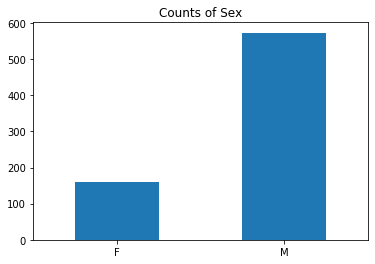

In [23]:
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

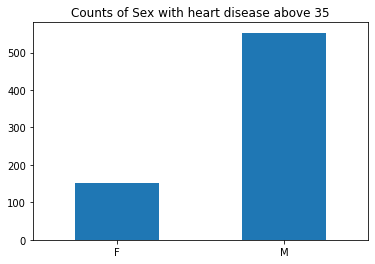

In [24]:
training_data["Sex"].where(training_data["Age"]  > 35).value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex with heart disease above 35", rot=0
)

In [25]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["HeartDisease"], training_data.drop(["HeartDisease"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["HeartDisease"], axis=1)
test_target = testing_data["HeartDisease"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [26]:
training_data.head()

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
865,1,54,1,0,120,188,0,1,113,0,1.4,1
706,1,61,0,0,130,330,0,0,169,0,0.0,2
405,1,35,1,0,120,0,1,1,130,1,1.2,1
249,1,49,1,0,130,341,0,1,120,1,1.0,1
697,1,58,1,0,150,270,0,0,111,1,0.8,2


In [28]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

In [29]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2022-03-22 23:31:16 Starting - Starting the training job...
2022-03-22 23:31:33 Starting - Preparing the instances for training..............
2022-03-22 23:32:49 Downloading - Downloading input data...
2022-03-22 23:33:10 Training - Downloading the training image...............
2022-03-22 23:34:31 Training - Training image download completed. Training in progress...
2022-03-22 23:34:46 Uploading - Uploading generated training model.
2022-03-22 23:34:52 Completed - Training job completed


In [30]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

In [33]:
model_name = "HeartDisease-clarify-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

'HeartDisease-clarify-model'

In [31]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="HeartDisease",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [34]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [35]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [36]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="Sex", facet_values_or_threshold=[0], group_name="Age"
)

In [37]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-03-22-23-40-46-135
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........

In [40]:
from IPython.display import Image
  
# get the image
Image(url="bias1.png", width=700, height=700)

In [53]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="HeartDisease",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [54]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-03-23-01-56-35-816
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMo

In [60]:
explainability_output_path

's3://sagemaker-us-east-1-837860013848/sagemaker/DEMO-sagemaker-clarify/clarify-explainability'

## Analysis of local explanations Sample 111

The Model has `11` input features. We computed KernelShap on the dataset         `dataset` and display the `10` features with the greatest feature attribution.
<br>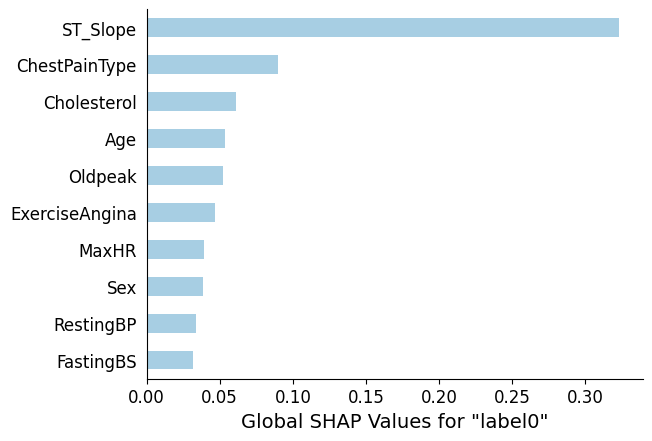<br>
<br>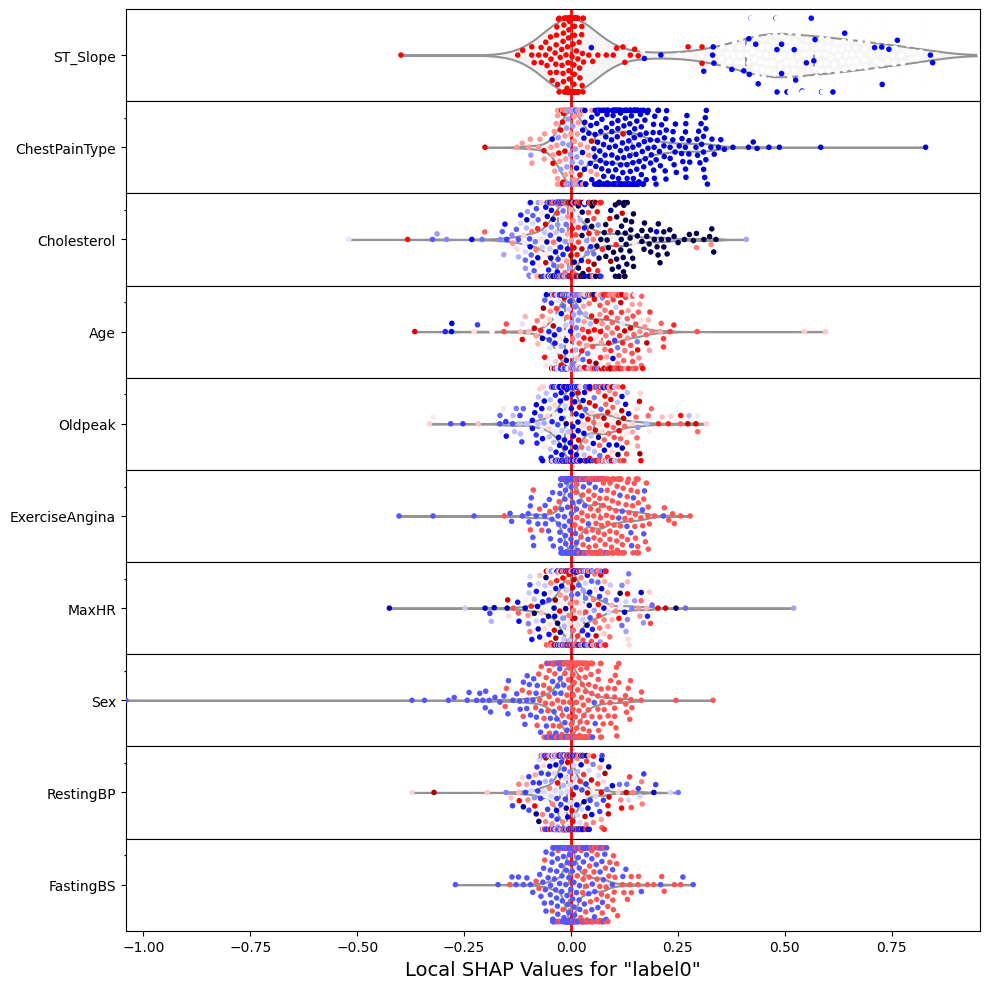<br>

In [61]:
session.delete_model(model_name)